# Importing packages

In [18]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# Function Definitions

In [2]:
def find_common_variable_nodes(H, syndrome):
    """
    Find common variable nodes connected to unsatisfied check nodes.
    Note: When there is only one unsatisfied check node, then it finds the variable node that is connected to it but not to any satisfied check node.
    When all check nodes are satisfied, then we obtain an empty dictionary.

    Parameters:
        H (numpy.ndarray): Parity-check matrix (m x n).
        syndrome (numpy.ndarray): Syndrome vector (1 x m).

    Returns:
        dict: A dictionary where keys are variable node indices and values are their counts.
    """
    ## Invalid input dimensions
    m, n = H.shape
    if len(syndrome) != m:
        raise ValueError("Dimensions of H and syndrome do not match.")

    ## To find indices where syndrome is non-zero (unsatisfied check nodes)
    unsatisfied_check_indices = np.where(syndrome != 0)[0]
    num_unsatisfied = len(unsatisfied_check_indices)

    ## To store variable nodes and their counts
    variable_counts = {}

    ## Case where there are no unsatisfied check nodes
    if num_unsatisfied == 0:
        return variable_counts

    ## Case where there is only one unsatisfied check node
    if num_unsatisfied == 1:

        ## Unsatisfied check node
        unsatisfied_check_index = unsatisfied_check_indices[0]

        ## Variable nodes connected to the unsatisfied check node
        unsatisfied_variable_nodes = set(np.where(H[unsatisfied_check_index, :] == 1)[0])

        ## Satisfied check nodes
        satisfied_check_indices = np.where(syndrome == 0)[0]

        ## Variable nodes connected to the satisfied check nodes
        satisfied_variable_nodes = set()
        for check_index in satisfied_check_indices:
            satisfied_variable_nodes.update(np.where(H[check_index, :] == 1)[0])

        ## Variable nodes that are connected to the unsatisfied check node but not to any satisfied check node
        uncommon_variable_nodes = unsatisfied_variable_nodes - satisfied_variable_nodes

        for var_node in uncommon_variable_nodes:
            variable_counts[var_node] = 1

        return variable_counts

    ## To find common variable nodes in all possible combinations of unsatisfied check nodes
    if num_unsatisfied > 1:
        ## To keep track of processed combinations of check nodes
        processed_combinations = set()

        ## Begin with the largest combination (of all unsatisfied check nodes) and work down to pairs
        for r in range(num_unsatisfied, 1, -1):
            ## Generate all combinations of size r
            for combo in combinations(unsatisfied_check_indices, r):
                ## Skip if this combination is a subset of any previously processed combination
                if any(set(combo).issubset(processed) for processed in processed_combinations):
                    continue

                ## To find the variable nodes for the current combination of check nodes
                variable_node_sets = []
                for check_index in combo:
                    row = H[check_index, :]
                    variable_nodes = np.where(row == 1)[0]
                    variable_node_sets.append(set(variable_nodes))

                ## Common variable nodes for a combination
                common_nodes = set.intersection(*variable_node_sets)

                if common_nodes:
                    for var_node in common_nodes:
                        if var_node in variable_counts:
                            variable_counts[var_node] += len(combo)
                        else:
                            variable_counts[var_node] = len(combo)

                    ## Processed combination
                    processed_combinations.add(frozenset(combo))

    return variable_counts

In [3]:
def flip_variable_nodes(H, syndrome, received_codeword):
    """
    Flip variable nodes in the received codeword based on the threshold (number of ones in each column of H).
    Note: It returns the original codeword only if there is one bit error in the received codeword.

    Parameters:
        H (numpy.ndarray): Parity-check matrix (m x n).
        syndrome (numpy.ndarray): Syndrome vector (1 x m).
        received_codeword (numpy.ndarray): Received codeword (1 x n).

    Returns:
        numpy.ndarray: Decoded codeword (1 x n).
    """
    ## Find common variable nodes and their counts
    variable_counts = find_common_variable_nodes(H, syndrome)

    ## Compute the threshold for each variable node (i.e, number of ones in each column of H)
    thresholds = np.sum(H, axis=0)

    decoded_codeword = received_codeword.copy()

    ## Flip variable nodes where the count exceeds or equals the threshold
    for var_node, count in variable_counts.items():
        if count >= thresholds[var_node]:
            decoded_codeword[var_node] = 1 - decoded_codeword[var_node]

    return decoded_codeword

In [4]:
# # Define a parity-check matrix H
# H = np.array([
#     [1, 1, 0, 1, 0, 0],
#     [0, 1, 1, 0, 1, 0],
#     [1, 1, 1, 0, 0, 1]
# ])

H = np.array([
    [1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 0, 0, 1, 1],
    [0, 0, 1, 1, 0, 1]
])

original_codeword = np.array([0, 0, 1, 0, 1, 1])
error_pattern = np.array([0, 0, 0, 0, 0, 1])

received_codeword = (original_codeword + error_pattern) % 2

print("Original Codeword:", original_codeword)
print("Error Pattern:", error_pattern)
print("Received Codeword:", received_codeword)

syndrome = np.mod(H @ received_codeword, 2)

print("Syndrome:", syndrome)

decoded_codeword = flip_variable_nodes(H, syndrome, received_codeword)

print("Decoded Codeword:")
print(decoded_codeword)

Original Codeword: [0 0 1 0 1 1]
Error Pattern: [0 0 0 0 0 1]
Received Codeword: [0 0 1 0 1 0]
Syndrome: [0 0 1 1]
Decoded Codeword:
[0 0 1 0 1 1]


In [5]:
original_codeword = np.array([0, 0, 1, 0, 1, 1])

In [6]:
original_codeword.shape

(6,)

In [14]:
def read_parity_check_matrix(file_path):
    with open(file_path, 'r') as file:
        n, m = map(int, file.readline().split())
        H = np.zeros((m, n), dtype=int)
        
        for i in range(m):
            line = file.readline().strip().split()
            if not line:
                continue  
            column_indices = list(map(int, line[1:]))
            for col in column_indices:
                H[i, col - 1] = 1  
    
    return H

file_path = "N40_M30_minD12_g8HA_L10.txt"
H_fromfile = read_parity_check_matrix(file_path)
print("Parity-check matrix H:")
print(H_fromfile)

Parity-check matrix H:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [15]:
H_fromfile.shape

(30, 40)

In [9]:
b = np.zeros((40,1))

In [10]:
a = np.zeros((40,1))
a[1] = 1
a[15] = 1
a[24] = 1
# a[35] = 1
# a[10] = 1

In [11]:
original_codeword = b
error_pattern = a

received_codeword = (original_codeword + error_pattern) % 2

print("Original Codeword:", original_codeword)
print("Error Pattern:", error_pattern)
print("Received Codeword:", received_codeword)

syndrome = np.mod(H_fromfile @ received_codeword, 2)

print("Syndrome:", syndrome)

decoded_codeword = flip_variable_nodes(H_fromfile, syndrome, received_codeword)

print("Decoded Codeword:")
print(decoded_codeword)

Original Codeword: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Error Pattern: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Received Codeword: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Syndrome: [[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
Decoded Codeword:
[[0.]
 [0.]
 [0

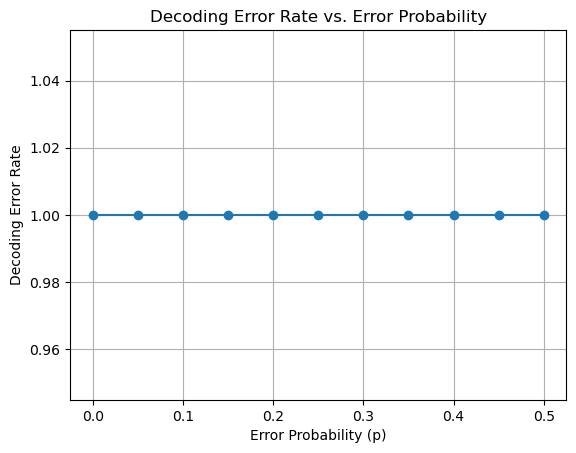

In [21]:
def monte_carlo_simulation(H, p, num_simulations=10):
    m, n = H.shape
    error_count = 0

    for _ in range(num_simulations):
        b = np.zeros((n,1))
        a = np.zeros((n,1))
        a[1], a[0], a[2] = 1, 1, 1

        original_codeword = b
        error_pattern = a
        
        received_codeword = (original_codeword + error_pattern) % 2
        syndrome = np.dot(H, received_codeword) % 2
        decoded_codeword = flip_variable_nodes(H, syndrome, received_codeword)

        if not np.array_equal(original_codeword, decoded_codeword):
            error_count += 1

    error_rate = error_count / num_simulations
    return error_rate

def plot_error_rate(H, p_values, num_simulations=1000):
    error_rates = []
    for p in p_values:
        error_rate = monte_carlo_simulation(H, p, num_simulations)
        error_rates.append(error_rate)
    
    plt.plot(p_values, error_rates, marker='o')
    plt.xlabel('Error Probability (p)')
    plt.ylabel('Decoding Error Rate')
    plt.title('Decoding Error Rate vs. Error Probability')
    plt.grid(True)
    plt.show()

p_values = np.linspace(0, 0.5, 11)
plot_error_rate(H, p_values, num_simulations=1000)